In [1]:
using Revise
include("../src/StatReg.jl")
using .StatReg

In [10]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))
myplot = plot(x, phi.(x), title="Real phi function",label=["Phi(x)"])
# savefig("real_phi.png")

300-element Array{Float64,1}:
 0.0                 
 0.020066889632107024
 0.04013377926421405 
 0.06020066889632107 
 0.0802675585284281  
 0.10033444816053512 
 0.12040133779264214 
 0.14046822742474915 
 0.1605351170568562  
 0.1806020066889632  
 0.20066889632107024 
 0.22073578595317725 
 0.2408026755852843  
 ⋮                   
 5.7792642140468224  
 5.79933110367893    
 5.8193979933110365  
 5.839464882943144   
 5.8595317725752505  
 5.879598662207358   
 5.8996655518394645  
 5.919732441471572   
 5.9397993311036785  
 5.959866220735786   
 5.9799331103678925  
 6.0                 

In [11]:
using QuadGK
kernel_name = "rectangular"
kernel(x::Real, y::Real) = getOpticsKernels(kernel_name)(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise
plot(y, f, title="$(kernel_name) kernel",label=["f(y)"],seriestype=:scatter, yerr=sig)
# savefig("integrated_$(kernel_name).png")

30-element Array{Float64,1}:
 0.035665211082106824
 0.07722247847559863 
 0.26649183641921187 
 0.6150166588904931  
 1.4567523347590916  
 2.632382287433087   
 3.068261027473606   
 3.379678437101014   
 3.9987619842155087  
 3.7422094104743455  
 3.7774357293562533  
 3.996293232483093   
 3.95988366757723    
 ⋮                   
 1.9972383914612637  
 1.6373496720041583  
 2.214383224847701   
 1.538325560021508   
 1.8194028929679282  
 1.207591438950991   
 0.6840218117395898  
 0.7240124143822582  
 0.456292455907382   
 0.26719626002294694 
 0.1060340060982488  
 0.03667128183434781 

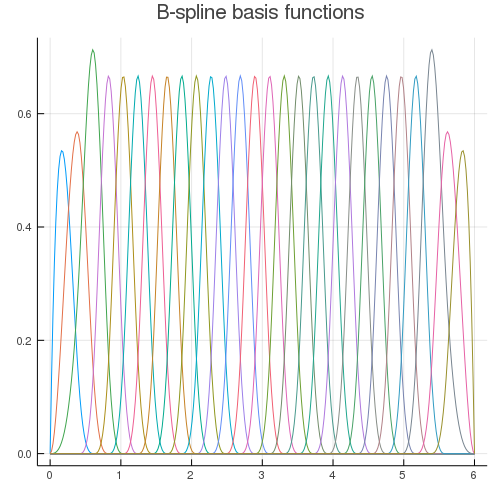

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:101


In [4]:
basis = CubicSplineBasis(y, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [5]:
Omega = omega(basis, 2)
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3])
println()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140


┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:161


In [6]:
result = solve(model, kernel, f, sig, y)
println()

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Starting find_optimal_alpha...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:17
┌ Info: Starting optimization...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:42
┌ Info: Optimized successfully, alphas = [0.0975087].
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:

In [7]:
edit("../src/utils/other_utils.jl")

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


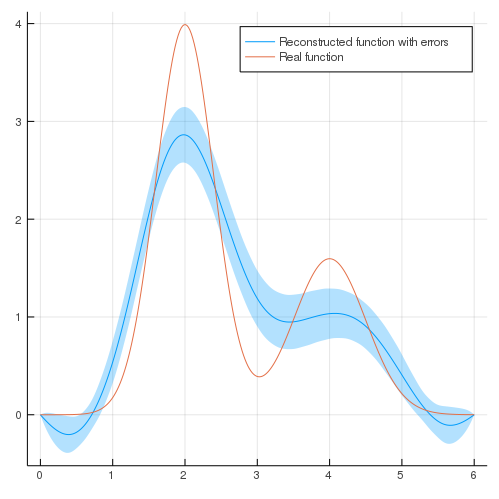

In [29]:
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")
# savefig("reconstructed.png")